In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
import numpy as np
import os
import random
import cv2
from keras.preprocessing.image import ImageDataGenerator,img_to_array
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!nvidia-smi

Tue May 31 02:09:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    34W / 250W |    375MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
!unzip "/content/drive/MyDrive/Project/Fake_fire/dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Valid/Fire/smoke-7527.jpg  
  inflating: dataset/Valid/Fire/smoke-7528.jpg  
  inflating: dataset/Valid/Fire/smoke-7529.jpg  
  inflating: dataset/Valid/Fire/smoke-7530.jpg  
  inflating: dataset/Valid/Fire/smoke-7531.jpg  
  inflating: dataset/Valid/Fire/smoke-7532.jpg  
  inflating: dataset/Valid/Fire/smoke-7533.jpg  
  inflating: dataset/Valid/Fire/smoke-7534.jpg  
  inflating: dataset/Valid/Fire/smoke-7535.jpg  
  inflating: dataset/Valid/Fire/smoke-7536.jpg  
  inflating: dataset/Valid/Fire/smoke-7537.jpg  
  inflating: dataset/Valid/Fire/smoke-7538.jpg  
  inflating: dataset/Valid/Fire/smoke-7539.jpg  
  inflating: dataset/Valid/Fire/smoke-7540.jpg  
  inflating: dataset/Valid/Fire/smoke-7541.jpg  
  inflating: dataset/Valid/Fire/smoke-7542.jpg  
  inflating: dataset/Valid/Fire/smoke-7543.jpg  
  inflating: dataset/Valid/Fire/smoke-7544.jpg  
  inflating: dataset/Valid/Fire/smoke-7545.jpg  
  inflating: datas

In [4]:
np.random.seed(1000)

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(256,256,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(2))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 96)       384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 256)      1

In [13]:
# Data generators
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Data flow
train_generator = train_datagen.flow_from_directory(
    directory="/content/dataset/Train/",
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    seed=42
)


Found 28061 images belonging to 2 classes.


In [14]:
print(train_generator.class_indices)


{'Fire': 0, 'Normal': 1}


In [15]:
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    directory="/content/dataset/Valid/",
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 7708 images belonging to 2 classes.


In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory="/content/dataset/Test",
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 5007 images belonging to 2 classes.


In [17]:
#Defining the parameters
batch_size= 256
epochs=100
learn_rate=.0001

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Project/Fake_fire/model.h5',
                                 monitor = 'val_accuracy',
                                 verbose = 1,
                                 save_best_only = True,
                                 mode='max')

In [ ]:
n_train_steps = train_generator.n//train_generator.batch_size
n_valid_steps = valid_generator.n//valid_generator.batch_size

# Compiling the model
#AlexNet.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])

In [7]:
AlexNet.load_weights("/content/drive/MyDrive/Project/Fake_fire/fire_detector.h5", by_name = True)
AlexNet.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [41]:
AlexNet.fit_generator(generator=train_generator,
                    steps_per_epoch=n_train_steps,
                    validation_data=valid_generator,
                    validation_steps=n_valid_steps,
                    callbacks = [checkpoint],
                    epochs = 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
876/876 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9902
Epoch 1: val_accuracy did not improve from 0.97643
876/876 [==============================] - 470s 537ms/step - loss: 0.0296 - accuracy: 0.9902 - val_loss: 0.4948 - val_accuracy: 0.8805
Epoch 2/10
876/876 [==============================] - ETA: 0s - loss: 0.0287 - accuracy: 0.9894
Epoch 2: val_accuracy did not improve from 0.97643
876/876 [==============================] - 459s 523ms/step - loss: 0.0287 - accuracy: 0.9894 - val_loss: 0.0882 - val_accuracy: 0.9740
Epoch 3/10
876/876 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9899
Epoch 3: val_accuracy did not improve from 0.97643
876/876 [==============================] - 471s 537ms/step - loss: 0.0279 - accuracy: 0.9899 - val_loss: 0.0923 - val_accuracy: 0.9746
Epoch 4/10
876/876 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.9897
Epoch 4: val_accuracy did not improve from 0.97643
876/876

In [42]:
AlexNet.save("/content/drive/MyDrive/Project/Fake_fire/fire_detector.h5", save_format="h5")

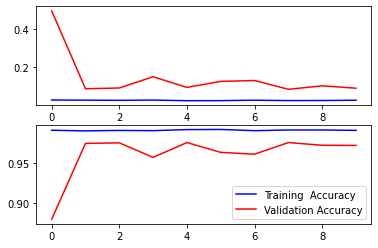

In [43]:
#After successful training, we will visualize its performance.

import matplotlib.pyplot as plt
#Plotting the training and validation loss

f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(AlexNet.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(AlexNet.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(AlexNet.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(AlexNet.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

In [18]:
inputPath = sorted(list(os.listdir('/content/dataset/Test')))
print(inputPath)

['Fire', 'Normal']


In [19]:
  data=[]
  labels=[]

  for img in inputPath:
      path = sorted(list(os.listdir("/content/dataset/Test/" + img)))
      for i in path:
          image = cv2.imread('/content/dataset/Test/'+img+'/'+i)
          image = img_to_array(image)
          data.append(image)
          l = label = img
          labels.append(l)
  data = np.array(data, dtype="float32") / 255.0
  labels = np.array(labels)
  mlb = LabelBinarizer()
  labels = mlb.fit_transform(labels)

print(data.shape)
print(labels.shape)

(5007, 256, 256, 3)
(5007, 1)


In [20]:
labels=to_categorical(labels)

print(data.shape, labels.shape)

(5007, 256, 256, 3) (5007, 2)


In [21]:
ypred = AlexNet.predict(data)

In [22]:
total = 0
accurate = 0
accurateindex = []
wrongindex = []
for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(labels[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
    total += 1

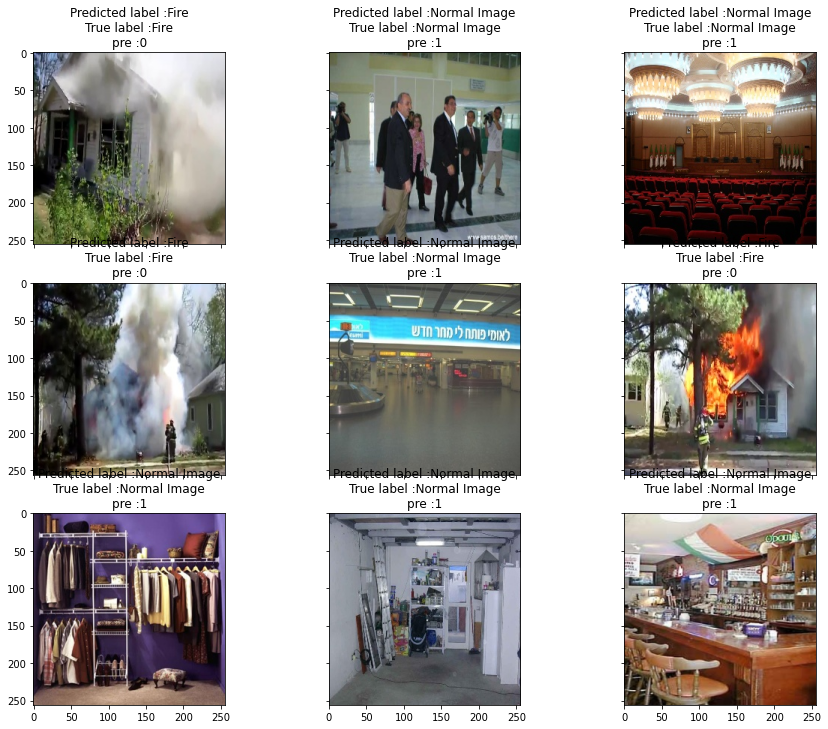

In [23]:
label=['Fire', 'Normal Image']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'
nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))
n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(cv2.cvtColor(data[imidx[n]], cv2.COLOR_BGR2RGB))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}\npre :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(labels[imidx[n]])],np.argmax(ypred[imidx[n]])))
            n += 1

plt.show()